# Дерево решений — регрессор
Регрессионное дерево делит пространство признаков на области и прогнозирует среднее значение цели внутри каждой области: $\hat{y}(x)=\frac{1}{|R_m|}\sum_{i:x_i\in R_m} y_i$. Разбиения выбираются по минимизации суммы квадратов ошибок, эквивалентной уменьшению дисперсии в узлах: $\min_{s,j}\left[\sum_{i\in R_1(s,j)} (y_i-\bar{y}_{R_1})^2 + \sum_{i\in R_2(s,j)} (y_i-\bar{y}_{R_2})^2\right]$. Глубина и минимальный размер листа контролируют переобучение.


## Используемые библиотеки
Подключаем `numpy`, `pandas` для вычислений и работы с таблицами, `seaborn` и `matplotlib` для графиков, из `sklearn` — загрузчик `load_diabetes`, `train_test_split`, `DecisionTreeRegressor` и регрессионные метрики.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
    validation_curve,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
SECONDARY_COLOR = "#ff7f0e"
HEATMAP_CMAP = "coolwarm"


## Датасет: описание и частичная распечатка
Датасет **Diabetes** из `sklearn` — 442 пациента, 10 нормализованных числовых признаков: возраст, пол, ИМТ, среднее артериальное давление и шесть биохимических показателей крови. Целевая переменная — **target**: количественная мера прогрессирования диабета через год после начала исследования. Задача — регрессия. Датасет небольшой, что делает его удобным для демонстрации склонности дерева к переобучению.


In [3]:
diabetes = load_diabetes(as_frame=True)
data = diabetes.frame
print(f"Размерность: {data.shape}")
data.head()


Размерность: (442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


## Предварительная обработка
Отделяем признаки от целевой переменной. Разбиваем на train/test (80/20). Деревья инвариантны к масштабу признаков — дополнительная стандартизация не нужна. Фиксируем `random_state=42` для воспроизводимости разбивки.


In [4]:
features = data.drop(columns=["target"])
target = data["target"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)


## Тепловая карта корреляций
Матрица корреляций для 10 признаков и целевой переменной. Видно, что **bmi** (ИМТ) и **s5** (уровень серотонина) наиболее коррелируют с прогрессированием диабета. Некоторые биохимические показатели коррелируют между собой — мультиколлинеарность не влияет на качество дерева, но полезна для интерпретации важности признаков.


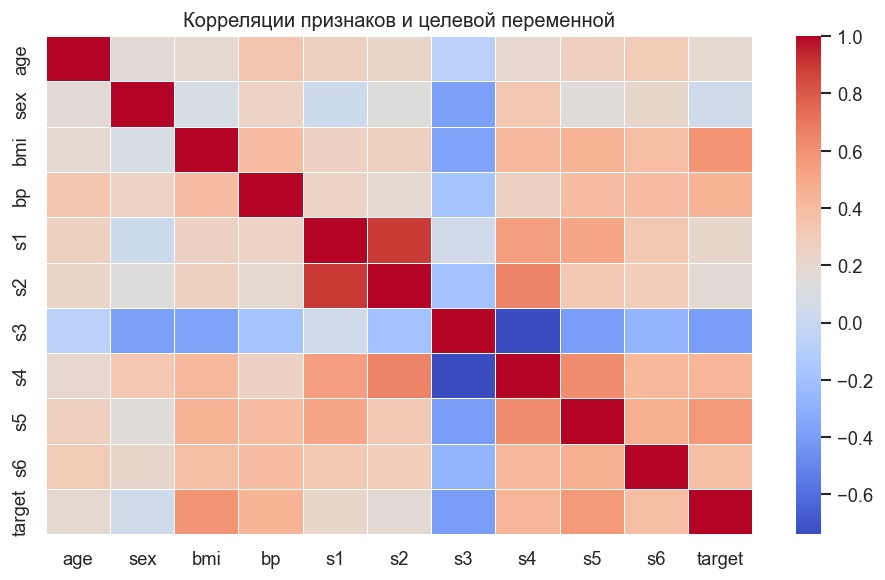

In [5]:
plt.figure(figsize=(8, 5))
correlation = data.corr()
sns.heatmap(correlation, annot=False, cmap=HEATMAP_CMAP, linewidths=0.5)
plt.title("Корреляции признаков и целевой переменной")
plt.tight_layout()
plt.show()


## Подбор гиперпараметров (RMSE, быстро)
Используем кросс-валидацию и оптимизируем **RMSE** (чем меньше, тем лучше). Для скорости берем компактную сетку.


In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)


In [7]:
# Быстрая сетка для дерева решений
# max_depth и min_samples_leaf сильнее всего влияют на переобучение

tree_param_grid = {
    "max_depth": [2, 3, 4, 5, 6],
    "min_samples_leaf": [2, 3, 4, 5, 6],
    "min_samples_split": [2, 5, 10],
}

tree_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    tree_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    refit=True,
)

tree_search.fit(X_train, y_train)
print("Лучшие параметры Decision Tree Regressor:", tree_search.best_params_)
print(f"Лучший CV RMSE: {-tree_search.best_score_:.2f}")


Лучшие параметры Decision Tree Regressor: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
Лучший CV RMSE: 63.39


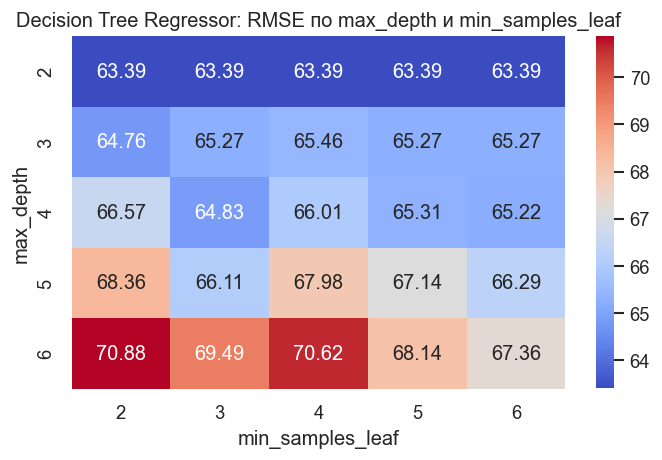

In [8]:
# Heatmap по двум параметрам при фиксированном лучшем min_samples_split

tree_results = pd.DataFrame(tree_search.cv_results_)
best_split = tree_search.best_params_["min_samples_split"]

tree_subset = tree_results[
    tree_results["param_min_samples_split"] == best_split
]

rmse_pivot = (-tree_subset.pivot_table(
    index="param_max_depth",
    columns="param_min_samples_leaf",
    values="mean_test_score",
))

plt.figure(figsize=(6, 4))
sns.heatmap(rmse_pivot, annot=True, fmt=".2f", cmap=HEATMAP_CMAP)
plt.title("Decision Tree Regressor: RMSE по max_depth и min_samples_leaf")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()


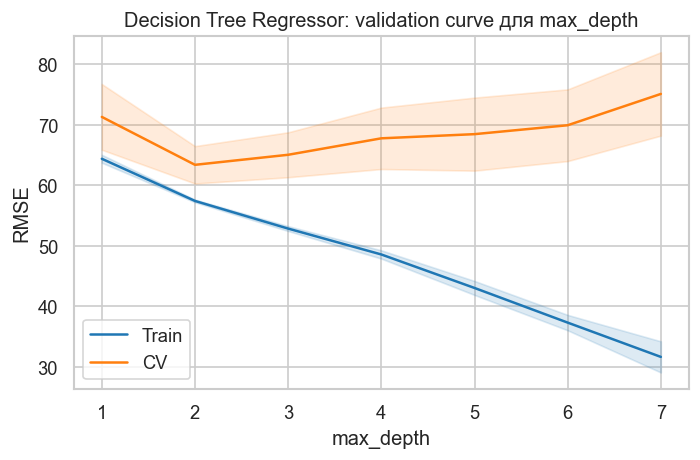

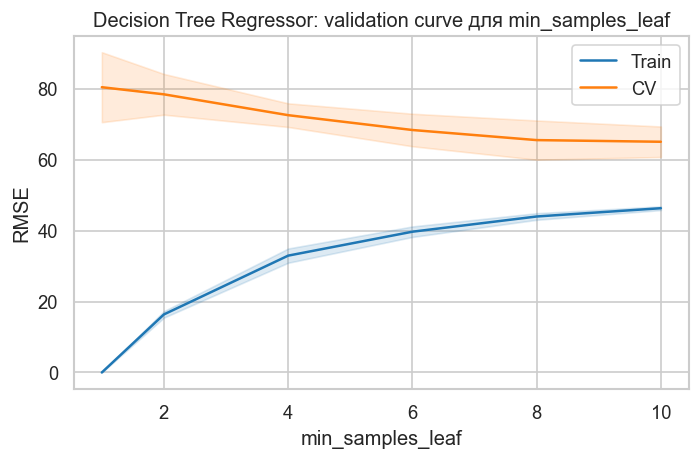

In [9]:
# Validation curves для дерева регрессии

def plot_validation_curve_reg(estimator, X, y, param_name, param_range, title):
    train_scores, valid_scores = validation_curve(
        estimator,
        X,
        y,
        param_name=param_name,
        param_range=param_range,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1,
    )
    train_mean = -train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    valid_mean = -valid_scores.mean(axis=1)
    valid_std = valid_scores.std(axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(param_range, train_mean, label="Train", color=PRIMARY_COLOR)
    plt.plot(param_range, valid_mean, label="CV", color=SECONDARY_COLOR)
    plt.fill_between(
        param_range,
        train_mean - train_std,
        train_mean + train_std,
        color=PRIMARY_COLOR,
        alpha=0.15,
    )
    plt.fill_between(
        param_range,
        valid_mean - valid_std,
        valid_mean + valid_std,
        color=SECONDARY_COLOR,
        alpha=0.15,
    )
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_validation_curve_reg(
    DecisionTreeRegressor(random_state=42),
    X_train,
    y_train,
    param_name="max_depth",
    param_range=[1, 2, 3, 4, 5, 6, 7],
    title="Decision Tree Regressor: validation curve для max_depth",
)

plot_validation_curve_reg(
    DecisionTreeRegressor(random_state=42),
    X_train,
    y_train,
    param_name="min_samples_leaf",
    param_range=[1, 2, 4, 6, 8, 10],
    title="Decision Tree Regressor: validation curve для min_samples_leaf",
)


## Обучение модели
Используем лучшую модель из подбора гиперпараметров. Ограничение глубины и минимального размера листа снижает переобучение и улучшает обобщающую способность.


In [10]:
model = tree_search.best_estimator_


## Прогнозы модели
Три регрессионные метрики:
- **MAE** — среднее отклонение в единицах целевой переменной;
- **RMSE** — штрафует крупные ошибки сильнее MAE;
- **R²** — 1.0 идеально, значения 0.4–0.6 типичны для дерева с ограниченной глубиной на этом датасете.


In [11]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Decision Tree Regressor Metrics")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.3f}")


Decision Tree Regressor Metrics
MAE:  49.37
RMSE: 61.12
R2:   0.295


## Графики выходных результатов
**График 1. Факт vs Прогноз.** Ступенчатый характер точек — особенность дерева: оно предсказывает конечное число уникальных значений (по одному на лист). Хорошая модель — точки вдоль диагонали.

**График 2. Важность признаков (Feature Importances).** Показывает вклад каждого признака в снижение MSE при разбиениях. **bmi** и **s5** должны лидировать — это соответствует корреляционному анализу.


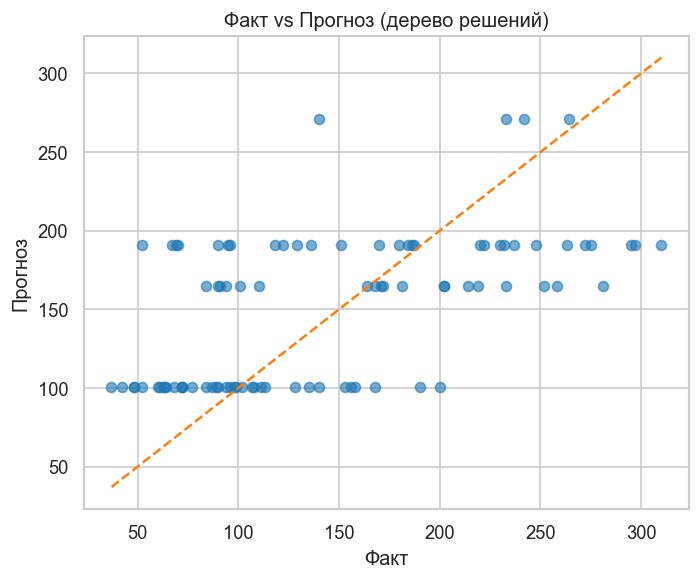

In [12]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color=PRIMARY_COLOR)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color=SECONDARY_COLOR,
    linestyle="--",
)
plt.xlabel("Факт")
plt.ylabel("Прогноз")
plt.title("Факт vs Прогноз (дерево решений)")
plt.tight_layout()
plt.show()


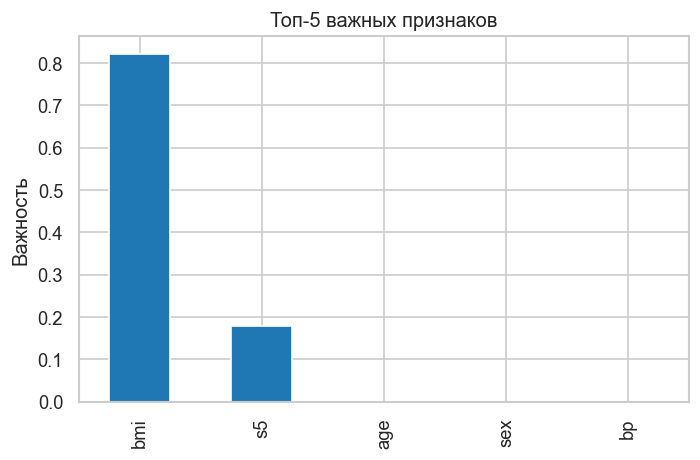

In [15]:
importance = pd.Series(model.feature_importances_, index=features.columns)
importance = importance.sort_values(ascending=False)
plt.figure(figsize=(6, 4))
importance.head(5).plot(kind="bar", color=PRIMARY_COLOR)
plt.ylabel("Важность")
plt.title("Топ-5 важных признаков")
plt.tight_layout()
plt.show()
